In [ ]:
# default_exp sparse.sparsifier

# Sparsifier

> Make your neural network sparse

In [ ]:
#hide
from nbdev.showdoc import *
from fastai.vision.all import *

In [ ]:
#export
import torch
import torch.nn as nn
from fastcore.basics import store_attr
from fasterai.sparse.criteria import *
from typing import Callable


In [ ]:
#hide
from torchvision.utils import make_grid
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='poster', style='white', font='sans-serif', font_scale=1, color_codes=True, rc=None)

%config InlineBackend.figure_format = 'retina'

A sparse vector, as opposed to a dense one, is a vector which contains a lot of zeroes. When we speak about making a neural network sparse, we thus mean that the network's weight are mostly zeroes.

With fasterai, you can do that thanks to the `Sparsifier` class.

Let's start by creating a model

In [ ]:
model = resnet18()

As you probably know, weights in a convolutional neural network have 4 dimensions ($ c_{out} \times c_{in} \times k_h \times k_w$)

In [ ]:
model.conv1.weight.ndim

4

In [ ]:
#hide
def plot_kernels(layer, save=None):
    kernels = layer.weight.detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    plt.figure(figsize=(10,10))
    img = make_grid(kernels, nrow=8, padding=1, pad_value=1)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

In the case of ResNet18, the dimension of the first layer weights is $64 \times 3 \times 7 \times 7$. We thus can plot each of the $64$ filter as a $7 \times 7$ color image (because they contains $3$ channels).

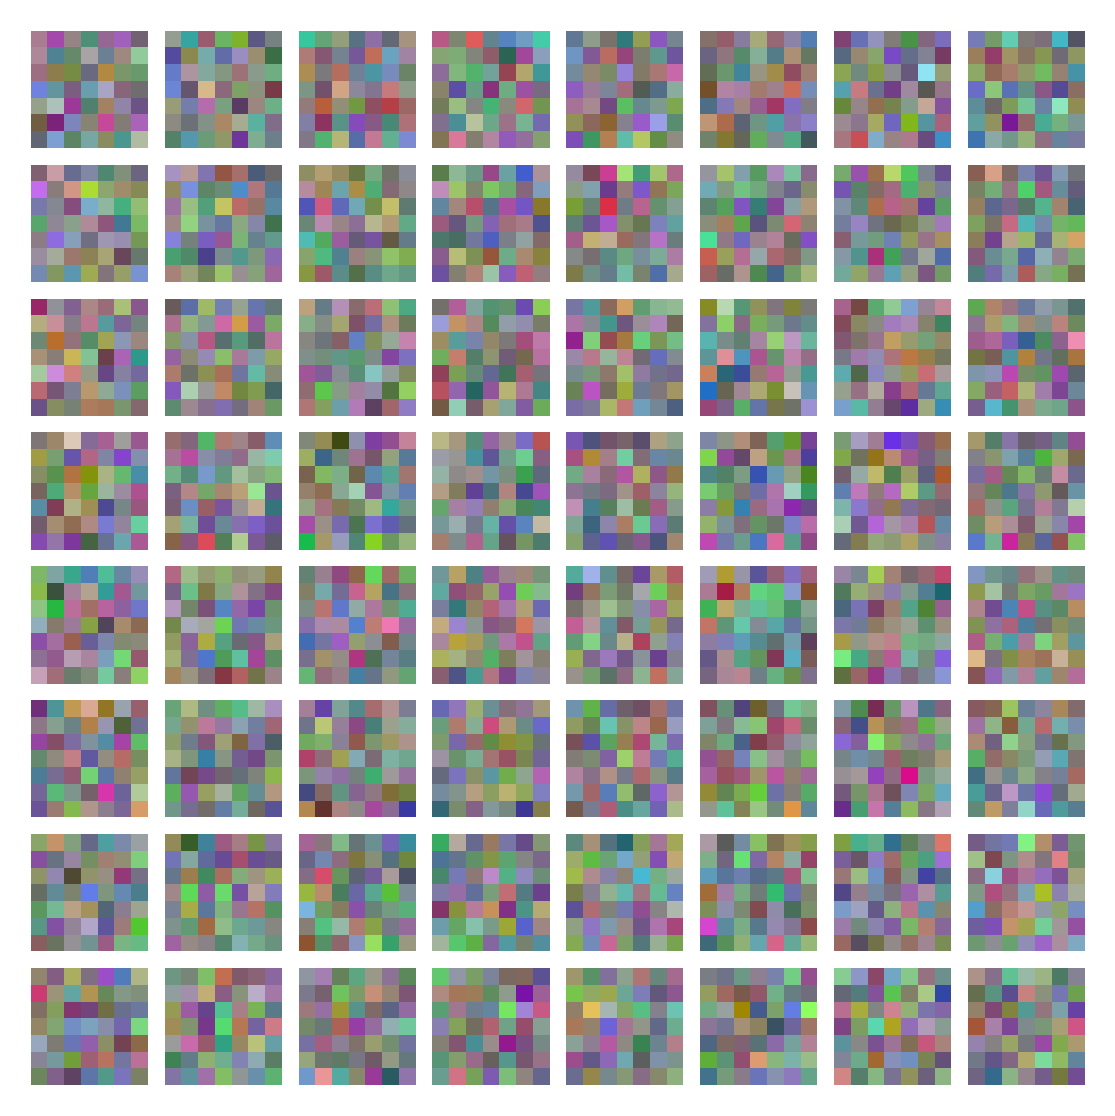

In [ ]:
plot_kernels(model.conv1)

In [ ]:
#export
class Sparsifier():

    def __init__(
        self, 
        model:Learner, 
        granularity:str, 
        method:Callable, 
        criteria)->None:
        
        store_attr()
        self._save_weights() # Save the original weights

    def prune_layer(self, module, sparsity):
        weight = self.criteria(module, self.granularity)
        mask = self._compute_mask(self.model, weight, sparsity)
        module.register_buffer("_mask", mask) # Put the mask into a buffer
        self._apply(module)

    def prune_model(self, sparsity):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d):
                self.prune_layer(m, sparsity)

    def _apply(self, module):
        mask = getattr(module, "_mask")
        module.weight.data.mul_(mask)

        if self.granularity == 'filter': # If we remove complete filters, we want to remove the bias as well
            if module.bias is not None:
                module.bias.data.mul_(mask.squeeze())

    def _mask_grad(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d) and hasattr(m, '_mask'):
                mask = getattr(m, "_mask")
                if m.weight.grad is not None: # In case some layers are freezed
                    m.weight.grad.mul_(mask)

                if self.granularity == 'filter': # If we remove complete filters, we want to remove the bias as well
                        if m.bias.grad is not None: # In case some layers are freezed
                            m.bias.grad.mul_(mask.squeeze())

    def _reset_weights(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Linear):
                init_weights = getattr(m, "_init_weights")
                m.weight.data = init_weights.clone()
            if isinstance(m, nn.Conv2d):
                init_weights = getattr(m, "_init_weights")
                m.weight.data = init_weights.clone()
                self._apply(m) # Reset the weights and apply the current mask

    def _save_weights(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.register_buffer("_init_weights", m.weight.clone())

    def _clean_buffers(self):
        for k, m in enumerate(self.model.modules()):
            if isinstance(m, nn.Conv2d) and hasattr(m, '_mask'):
                del m._buffers["_mask"]

            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                del m._buffers["_init_weights"]


    def _compute_mask(self, model, weight, sparsity):
        if self.method == 'global':
            global_weight = torch.cat([self.criteria(m, self.granularity).view(-1) for m in model.modules() if isinstance(m, nn.Conv2d)])
            threshold = torch.quantile(global_weight, sparsity/100) # Compute the threshold globally

        elif self.method == 'local':
            threshold = torch.quantile(weight.view(-1), sparsity/100) # Compute the threshold locally

        else: raise NameError('Invalid Method')

        if threshold > weight.max(): threshold = weight.max() # Make sure we don't remove every weight of a given layer

        mask = weight.ge(threshold).to(dtype=weight.dtype)

        return mask

The `Sparsifier` class allows us to remove some (part of) the filters, that are considered to be less useful than others. This can be done by first creating an instance of the class, specifying:

- The `granularity`, i.e. the part of filters that you want to remove. Typically, we usually remove weights, vectors, kernels or even complete filters.
- The `method`, i.e. if you want to consider each layer independently (`local`), or compare the parameters to remove across the whole network (`global`).
- The `criteria`, i.e. the way to assess the usefulness of a parameter. Common methods compare parameters using their magnitude, the lowest magnitude ones considered to be less useful.

Once this is specified, just use the `Sparsifier.prune_model`, indicating the percentage of sparsity to you want to apply. One can also specify a single layer to prune by using the  `Sparsifier.prune_layer` method.

In [ ]:
show_doc(Sparsifier.prune_model)

<h4 id="Sparsifier.prune_model" class="doc_header"><code>Sparsifier.prune_model</code><a href="__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>Sparsifier.prune_model</code>(**`sparsity`**)



There are several ways in which we can make that first layer sparse. You will find the most important below:

## Pruning individual weights

As a reminder, the first convolutional layer of ResNet18 could be represented as a $64 \times 3 \times 7 \times 7$ tensor, meaning that the whole layer posess $9408$ weights.

When removing individual weights, we do not impose any constraint on where in the first layer the weight removed should come from. We only compare them all together and remove the ones that are the least important, according to our `criteria`. We thus remove $0d$ blocks from our $4d$ weight tensor.

Here is for example how you would proceed to remove $80 \%$ of the weights of the network.

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'local', large_final)
pruner.prune_layer(model.conv1, 80)

And here are what the first layer filters would look like.

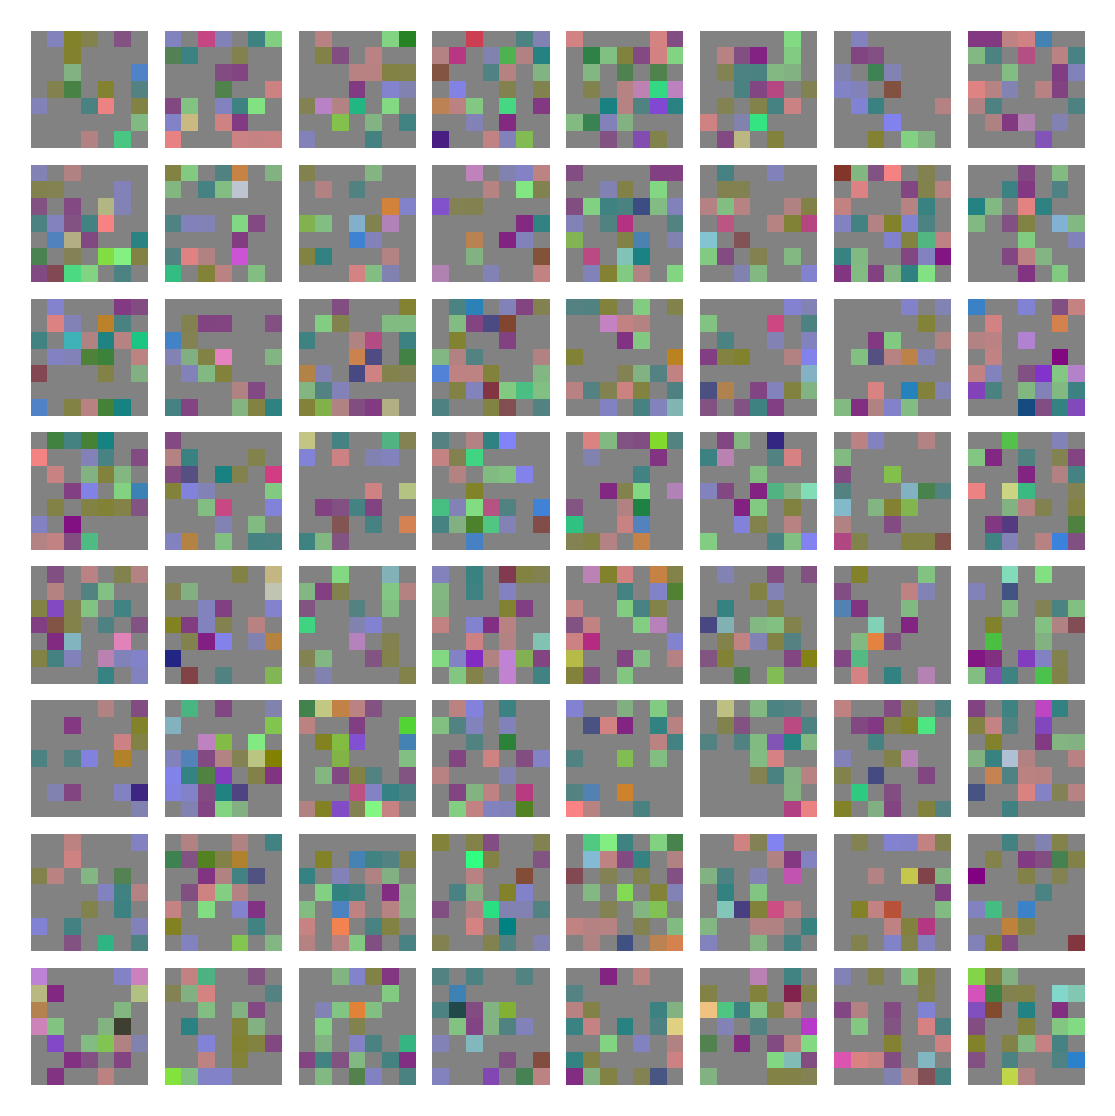

In [ ]:
plot_kernels(model.conv1)

## Pruning Vectors

When removing vectors, we don't compare $9408$ weights anymore as we now impose to remove complete vectors of weights from the first layer. We now remove $1d$ blocks from our layer and can chose to remove `column` vectors from the filters, but also `row` of `channel` vectors. In those cases, we thus compare respectively $64 \times 3 \times 7$ column vectors, or $64 \times 7 \times 3$ row vectors, or $64 \times 7 \times 7$ channel vectors, and remove the least important according to our criteria.

The consequence is that, we now start to see some structure emerging in our remaining weights.  

> Note: If you look closely, you will see some red/green/blue vectors remaining. This means that we removed the 2 other vectors corresponding to the same spatial location but located at other color channel.

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'vector', 'local', large_final)
pruner.prune_layer(model.conv1, 80)

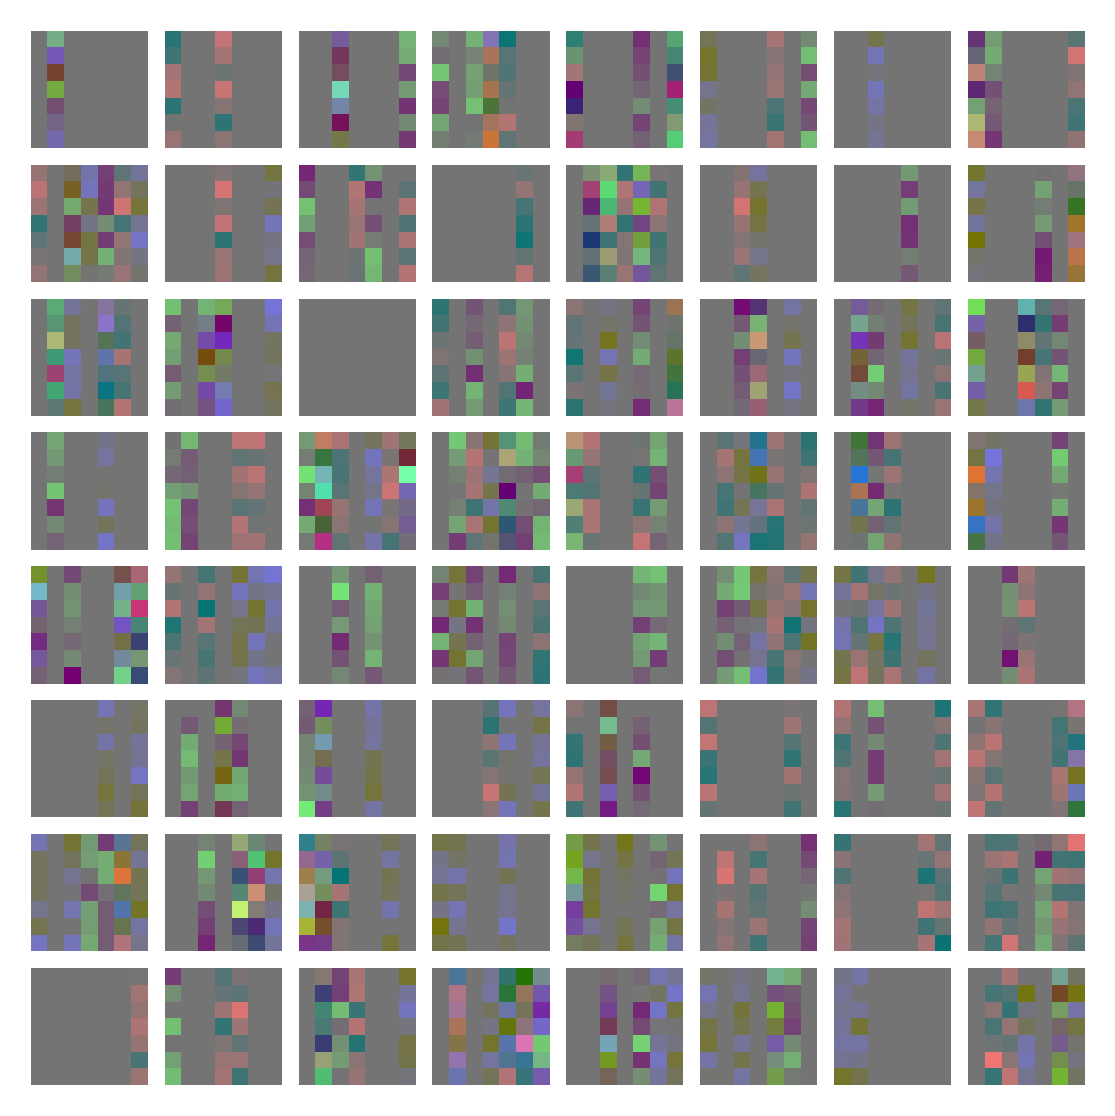

In [ ]:
plot_kernels(model.conv1)

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'row', 'local', large_final)
pruner.prune_layer(model.conv1, 80)

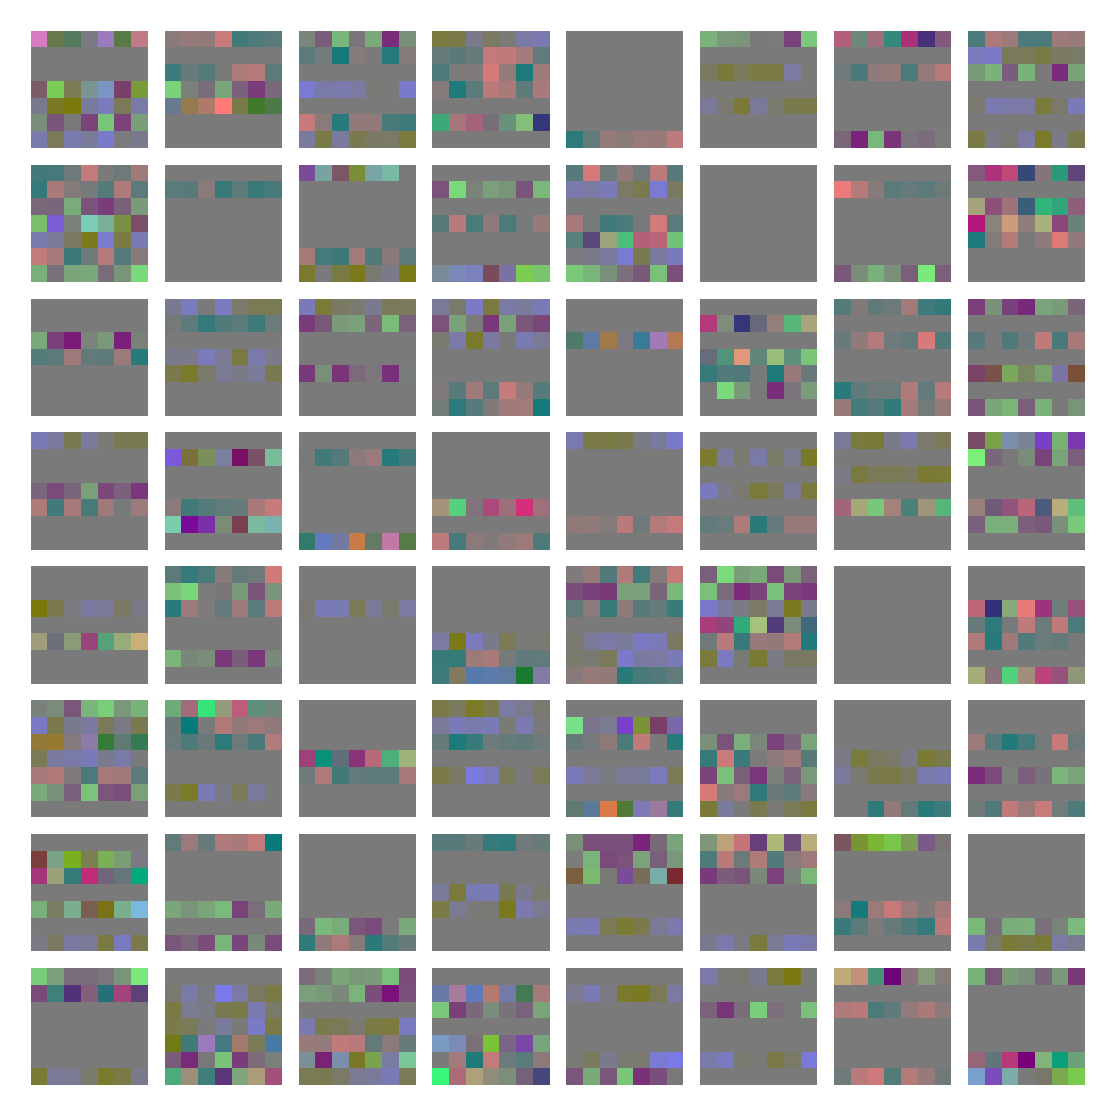

In [ ]:
plot_kernels(model.conv1)

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'channel', 'local', large_final)
pruner.prune_layer(model.conv1, 80)

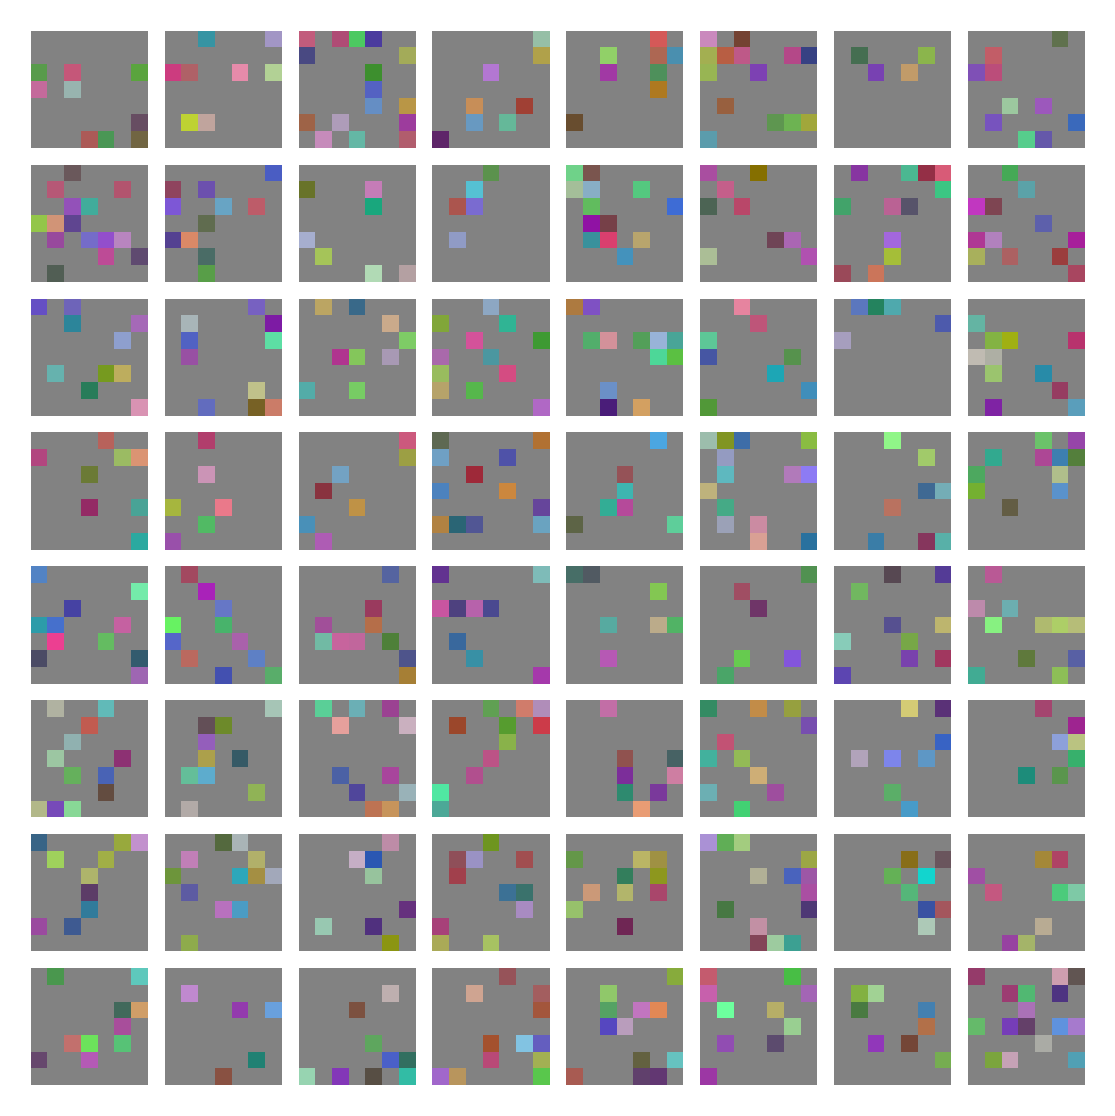

In [ ]:
plot_kernels(model.conv1)

## Pruning Kernels

Having a network sparse kernel-wise means that we removed $2d$ blocks from our filter (generally from a spatial point of view). In our case, it means comparing each of the $64 \times 3$ kernels and removing the least important ones.

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'kernel', 'local', large_final)
pruner.prune_layer(model.conv1, 80)

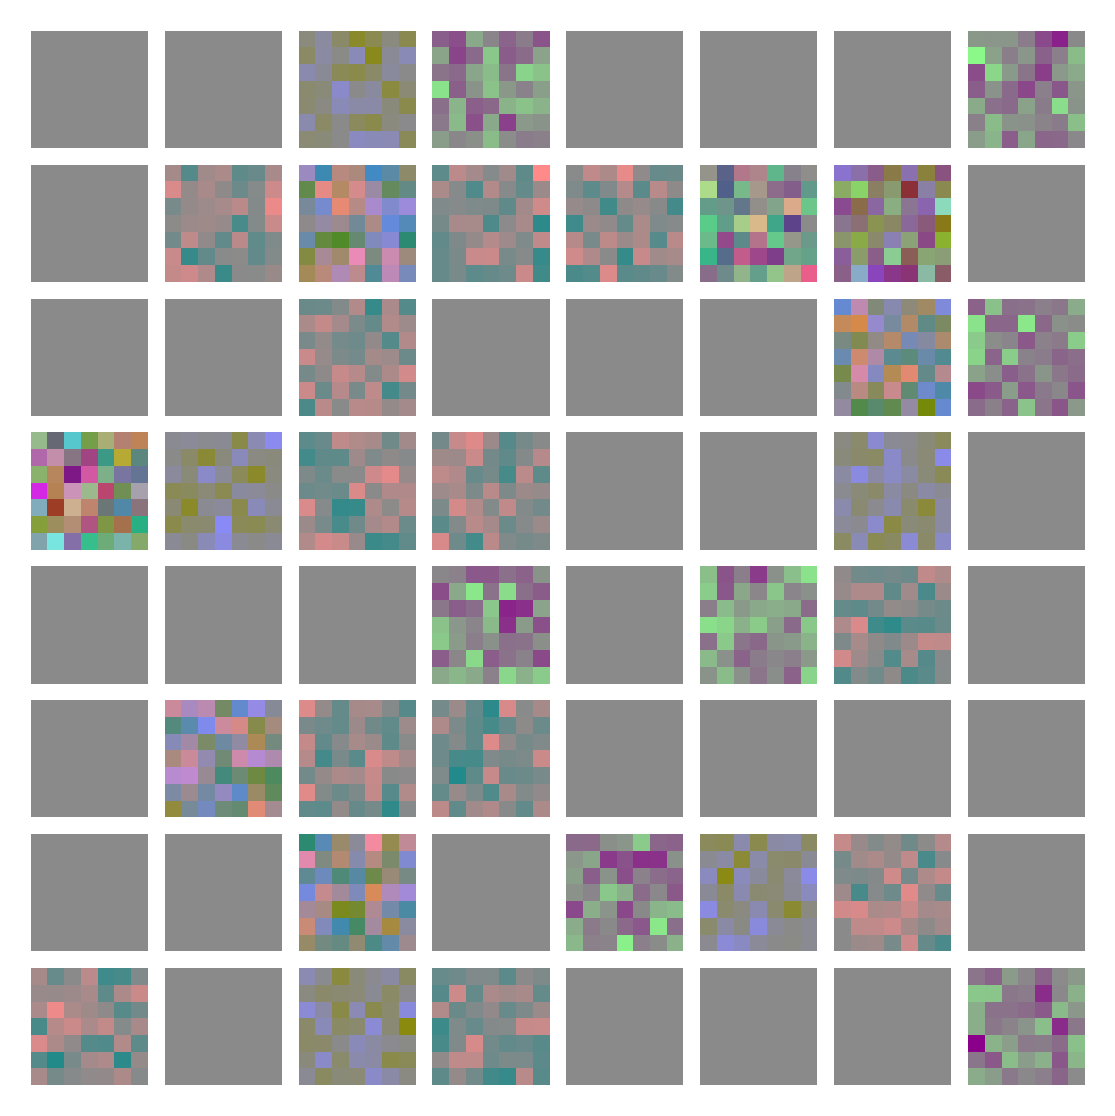

In [ ]:
plot_kernels(model.conv1)

## Pruning Filters

Finally, we can choose to remove entire filters. This means that now, we compare the $64$ filters together, thus removing $3d$ blocks.

In [ ]:
model = resnet18()
pruner = Sparsifier(model, 'filter', 'local', large_final)
pruner.prune_layer(model.conv1, 80)

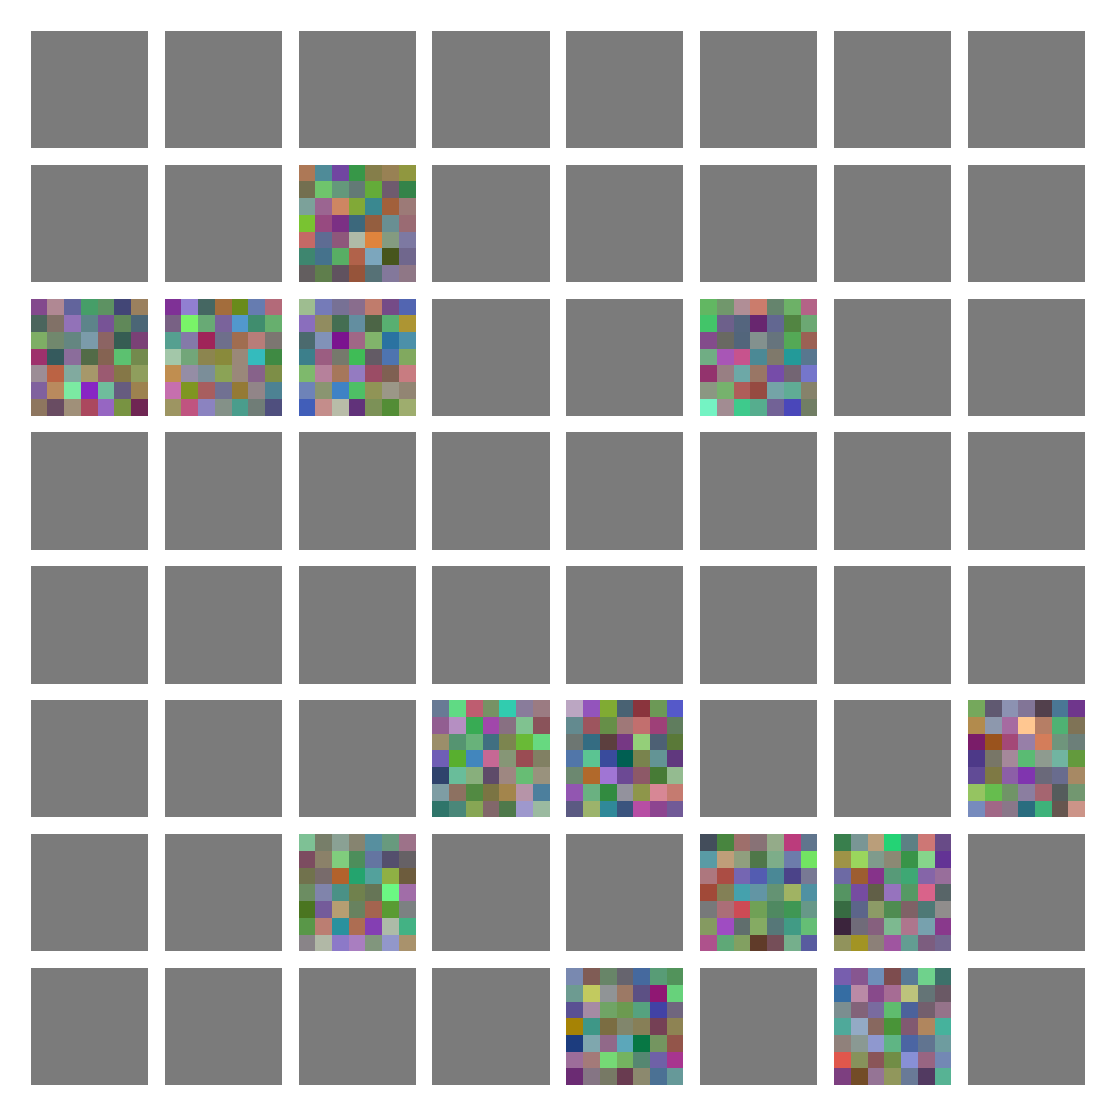

In [ ]:
plot_kernels(model.conv1)